<a href="https://colab.research.google.com/github/TianYubo/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers_cn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤗 Diffusers 简介

![diffusers_library](https://github.com/huggingface/diffusers/raw/main/docs/source/en/imgs/diffusers_library.jpg)

在本笔记本中，你将训练你的第一个扩散模型来**生成可爱的蝴蝶图像 🦋。** 在此过程中，你将了解 🤗 Diffusers 库的核心组件，这将为我们在课程后续部分讲到的更高级应用打下良好的基础。

让我们开始吧！

## 你会学到什么

在这个笔记本中，你将：

- 看到一个强大的自定义扩散模型管道的实际操作（以及如何制作你自己的版本的信息）
- 创建你自己的迷你管道：
  - 回顾扩散模型背后的核心思想
  - 从Hub加载数据以进行训练
  - 探索我们如何使用调度器向这些数据添加噪声
  - 创建和训练UNet模型
  - 将各个部分组合成一个可工作的管道
- 编辑并运行一个脚本以初始化更长时间的训练运行，该脚本将处理：
  - 通过🤗 Accelerate实现多GPU训练
  - 实验记录以跟踪关键统计信息
  - 将最终模型上传到Hugging Face Hub

❓如果你有任何问题，请在Hugging Face Discord服务器的`#diffusion-models-class`频道上发布。如果你还没有注册，可以在此处注册：https://huggingface.co/join/discord

## 先决条件

在开始学习笔记本之前，您应该：

* 📖 阅读第1单元的材料
* 🤗 在Hugging Face Hub上创建一个帐户。如果您还没有这样做，可以在此处进行：https://huggingface.co/join

## 第1步：设置

运行以下单元格以安装 diffusers 库以及其他几个要求：

In [2]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pyarrow (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pyarrow
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pyarrow)


接下来，前往 https://huggingface.co/settings/tokens 并创建一个具有写入权限的访问令牌（access token），如果你还没有的话：

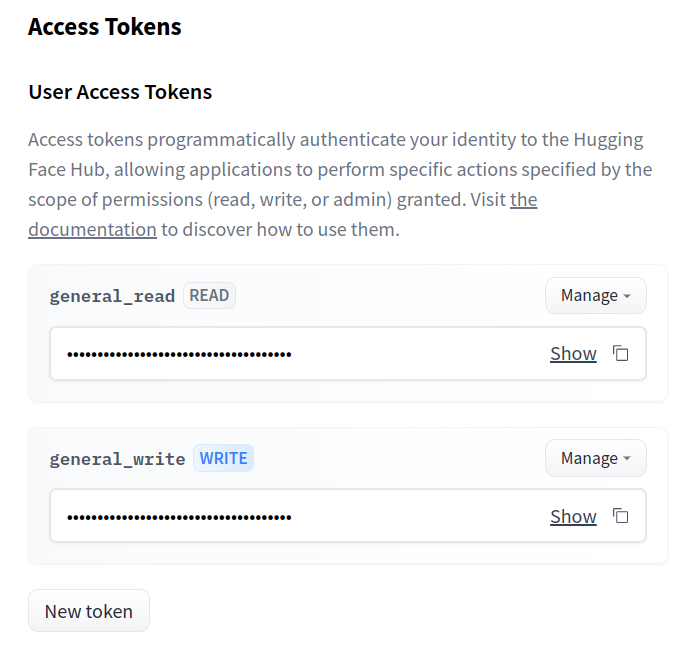

你可以通过以下令牌使用命令行登录（`huggingface-cli login`），或者通过运行以下单元格进行登录：

In [3]:
from huggingface_hub import notebook_login

notebook_login()

然后你需要安装 Git-LFS 来上传你的模型检查点：

In [4]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

最后，让我们导入将在本笔记本中使用的库，并定义一些之后会在笔记本中用到的便捷函数：

In [5]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

好的，我们都准备好了！

## Dreambooth: A Sneak Peak at What's to Come

如果你在过去的几个月里看过与AI相关的社交媒体，你一定听说过Stable Diffusion。它是一个强大的文本条件下的潜在扩散模型（别担心，我们会学习这些术语的含义）。但是它有一个缺陷：除非我们有名到照片遍布互联网，否则它不知道你或我长什么样。

Dreambooth让我们可以创建自己的模型变体，并添加特定人脸、物体或风格的额外信息。The Corridor Crew使用这种方法制作了一个优秀的视频，通过一致的角色来讲述故事，这是这种技术能够实现的效果的一个很好的例子：

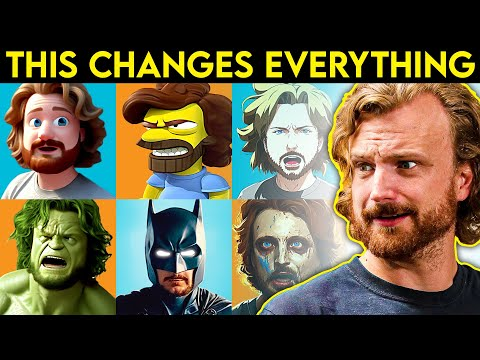

In [6]:
from IPython.display import YouTubeVideo

YouTubeVideo("W4Mcuh38wyM")

这里有一个例子，使用了[一个模型](https://huggingface.co/sd-dreambooth-library/mr-potato-head)，该模型基于一个名为 "Mr Potato Head "的流行儿童玩具的5张照片进行训练。

首先，我们加载管道。这将从Hub下载模型权重等。由于这将会为一个一行的演示下载好几个千兆的数据，欢迎您跳过这个单元格，直接欣赏示例输出！

In [7]:
from diffusers import StableDiffusionPipeline

# Check out https://huggingface.co/sd-dreambooth-library for loads of models from the community
model_id = "sd-dreambooth-library/mr-potato-head"

# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    device
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/589 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.67k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/597 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--sd-dreambooth-library--mr-potato-head/snapshots/34246b94acd8b96166e8d93eaded001c380a2d4e/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--sd-dreambooth-library--mr-potato-head/snapshots/34246b94acd8b96166e8d93eaded001c380a2d4e/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--sd-dreambooth-library--mr-potato-head/snapshots/34246b94acd8b96166e8d93eaded001c380a2d4e/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--sd-dreambooth-library--mr-potato-head/snapshots/34246b94acd8b96166e8d93eaded001c380a2d4e/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


一旦管道加载完成，我们可以用以下代码生成图像：

  0%|          | 0/50 [00:00<?, ?it/s]

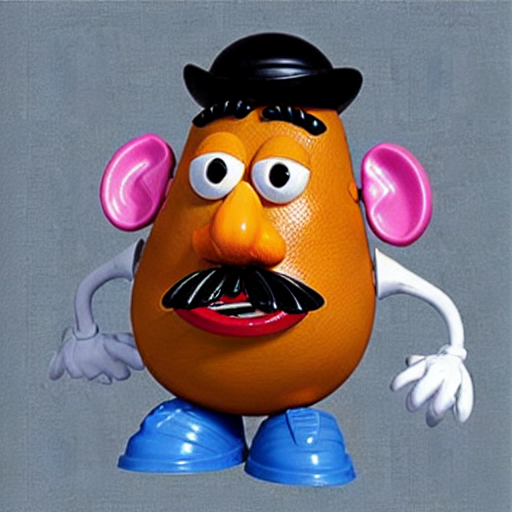

In [8]:
prompt = "an abstract oil painting of sks mr potato head by picasso"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image

**练习：** 尝试使用不同的提示语自己操作一下。`sks` 令牌在此情况下代表小说概念的独特标识符 - 如果你将其省略会发生什么？你还可以尝试更改采样步骤的数量（你能降到多低？）和 `guidance_scale`，它决定了模型将尝试与提示语匹配的程度。

  0%|          | 0/50 [00:00<?, ?it/s]

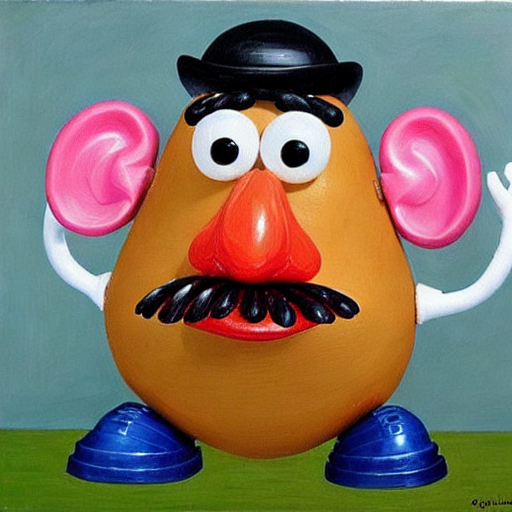

In [11]:
prompt = "an abstract oil painting of mr potato head by picasso"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image

在那个神奇的pipeline中发生了许多事情！到课程结束时，你将了解它是如何工作的。现在，让我们看看如何从头开始训练一个diffusion model。

## MVP (Minimum Viable Pipeline)

🤗 Diffusers 的核心 API 分为三个主要组件：
1. **Pipelines**：高级类，旨在以用户友好的方式快速从流行的训练扩散模型生成样本。
2. **Models**：用于训练新扩散模型的流行架构，例如 [UNet](https://arxiv.org/abs/1505.04597)。
3. **Schedulers**：在 *inference* 期间从噪声生成图像的各种技术，以及为 *training* 生成带噪声的图像。

Pipelines 对最终用户非常友好，但如果你来参加这门课程，我们假设你想知道它内部的工作原理！因此，在本笔记本的其余部分，我们将构建自己的管道，用于生成小型蝴蝶图片。以下是最终结果的实际效果：

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--johnowhitaker--ddpm-butterflies-32px/snapshots/ff99059aed185f6158729b8e9f2286c4b9c177f3: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--johnowhitaker--ddpm-butterflies-32px/snapshots/ff99059aed185f6158729b8e9f2286c4b9c177f3.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/1000 [00:00<?, ?it/s]

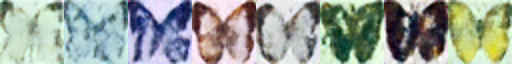

In [13]:
from diffusers import DDPMPipeline

# Load the butterfly pipeline
butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)

# Create 8 images
images = butterfly_pipeline(batch_size=8).images

# View the result
make_grid(images)

或许不如 DreamBooth 示例那么令人印象深刻，但我们要知道，我们是从头开始训练的，并且使用的数据量仅为训练 Stable Diffusion 所用数据的 ~0.0001%。说到训练，回想一下本单元的介绍部分，训练一个扩散模型的过程大致如下：


1.   从训练数据中加载一些图像
2.   添加不同量的噪声。
3.   将输入的噪声版本送入模型
4.   评估模型对这些输入去噪的效果
5.   使用此信息更新模型权重，并重复

在接下来的几个部分中，我们将逐步探讨这些步骤，直到实现一个完整的训练循环。然后，我们将研究如何从训练好的模型中采样，以及如何将所有内容打包成一个管道以方便分享。让我们从数据开始吧...

## 第 2 步：下载训练数据集

在这个例子中，我们将使用来自 Hugging Face Hub 的图像数据集。具体来说，[这组包含 1000 张蝴蝶图片的集合](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset)。这是一个非常小的数据集，因此我们还包含了几个更大选项的注释掉的代码行。如果你更希望使用自己的图像集合，也可以使用注释掉的代码示例从文件夹中加载图片。

In [ ]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Or load images from a local folder
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Using custom data configuration huggan--smithsonian_butterflies_subset-7665b1021a37404c
Found cached dataset parquet (/home/lewis_huggingface_co/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


我们可以获取一批图像并查看其中的一些，如下所示：

X shape: torch.Size([8, 3, 32, 32])


/tmp/ipykernel_4278/3975082613.py:3: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)


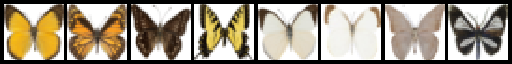

In [ ]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

我们坚持使用一个小数据集，图像大小为32像素，以保持在此笔记本中的训练时间可管理。

## 第3步：定义调度器

我们的训练计划是获取这些输入图像并添加噪声，然后将带有噪声的图像输入模型。而在推理过程中，我们将使用模型的预测结果来迭代地去除噪声。在 `diffusers` 中，这些过程都由 **scheduler** 来处理。

噪声调度决定了在不同时间步骤中添加多少噪声。以下是我们如何使用 'DDPM' 训练和采样的默认设置创建一个调度器（基于论文 ["Denoising Diffusion Probabilistic Models"](https://arxiv.org/abs/2006.11239)）：

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

DDPM论文描述了一种 corruption 过程，该过程在每个 'timestep' 添加少量噪声。给定某个时间步的 $x_{t-1}$，我们可以通过以下公式得到下一个（略微更噪）版本 $x_t$：<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


也就是说，我们取 $x_{t-1}$，将其缩放 $\sqrt{1 - \beta_t}$ 倍，并添加按 $\beta_t$ 缩放的噪声。这个 $\beta$ 根据某个调度策略为每个 t 定义，并决定了每个时间步添加多少噪声。现在，我们不一定想执行 500 次此操作来得到 $x_{500}$，因此我们有另一个公式，可以给定 $x_0$ 得到任意 t 的 $x_t$：<br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, {(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ 其中 $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ 且 $\alpha_i = 1-\beta_i$<br><br>

数学符号看起来总是令人畏惧！幸运的是，scheduler 会为我们处理所有这些。我们可以绘制 $\sqrt{\bar{\alpha}_t}$（标记为 `sqrt_alpha_prod`）和 $\sqrt{(1 - \bar{\alpha}_t)}$（标记为 `sqrt_one_minus_alpha_prod`），以查看输入 (x) 和噪声在不同时间步如何被缩放和混合：

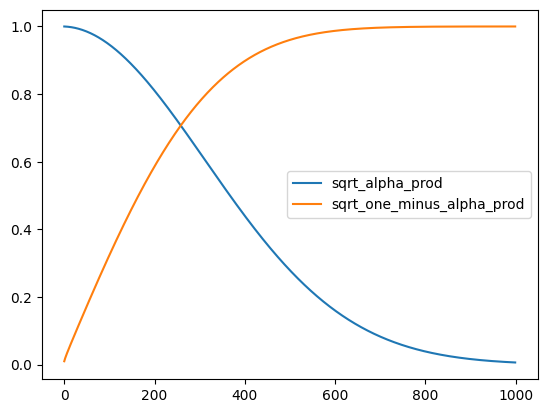

In [ ]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

**练习：** 你可以通过在这里替换为其中一个被注释掉的选项，来探索此图在不同 beta_start、beta_end 和 beta_schedule 设置下的变化：

In [ ]:
# One with too little noise added:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
# The 'cosine' schedule, which may be better for small image sizes:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

无论你选择了哪种调度器，我们现在都可以使用它通过 `noise_scheduler.add_noise` 函数以不同的量添加噪声，如下所示：

Noisy X shape torch.Size([8, 3, 32, 32])


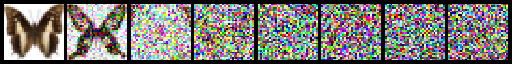

In [ ]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

再次，探索使用不同的噪声时间表和参数的影响。[这个视频](https://www.youtube.com/watch?v=fbLgFrlTnGU) 非常好地详细解释了上述的一些数学内容，并且是这些概念的一个很好的入门介绍。

## 第4步：定义模型

现在我们来到核心组件：模型本身。

大多数扩散模型使用的是某种形式的 [U-net](https://arxiv.org/abs/1505.04597) 架构，这里我们也将使用它。

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

简而言之：
- 模型将输入图像通过多个 ResNet 层块，每个层块会将图像尺寸缩小一半。
- 然后通过相同数量的块将其再次上采样。
- 存在跳跃连接（skip connections），将下采样路径上的特征链接到上采样路径中对应的层。

该模型的一个关键特性是，它预测的图像大小与输入图像大小相同，这正是我们此处所需的功能。

Diffusers 提供了一个方便的 `UNet2DModel` 类，它可以在 PyTorch 中创建所需的架构。

让我们为我们的目标图像大小创建一个 U-net。
注意，`down_block_types` 对应于下采样块（上图中的绿色部分），而 `up_block_types` 是上采样块（上图中的红色部分）：

In [ ]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

在处理更高分辨率的输入时，你可能希望使用更多的下采样和上采样模块，并仅在最低分辨率（底部）层保留注意力层，以减少内存使用。我们稍后会讨论如何通过实验找到最适合你应用场景的最佳设置。

我们可以检查输入一批数据和一些随机的时间步长是否会产生与输入数据形状相同的输出：

In [ ]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

在下一节中，我们将看到如何训练这个模型。

## 第5步：创建训练循环

开始训练！以下是 PyTorch 中一个典型的优化循环，我们通过数据一批一批地运行，并在每一步使用优化器更新模型的参数——在这种情况下，我们使用的是学习率为 0.0004 的 AdamW 优化器。

对于每一批数据，我们
- 采样一些随机时间步
- 按照相应的方式对数据添加噪声
- 将加噪后的数据输入模型
- 使用均方误差作为损失函数，将模型预测结果与目标（即在此情况下的噪声）进行比较
- 通过 `loss.backward()` 和 `optimizer.step()` 更新模型参数

在此过程中，我们还会记录随时间变化的损失值，以便后续绘图。

注意：此代码运行需要近 10 分钟——如果你赶时间，可以跳过这两个单元格，直接使用预训练模型。或者，你可以探索通过上方模型定义中减少每一层的通道数来加速训练。

[官方 diffusers 训练示例](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb) 在此数据集上以更高分辨率训练了一个更大的模型，是一个了解较不简化的训练循环的良好参考：

In [ ]:
# 设置噪声调度器 (Noise Scheduler)
# DDPMScheduler 是一种用于扩散模型 (Diffusion Models) 的调度器，用于定义训练时的时间步数和噪声分布。
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,  # 训练过程中使用的时间步数 (timesteps) 总数
    beta_schedule="squaredcos_cap_v2"  # 使用的 beta 调度策略，定义了噪声的变化方式
)

# 设置优化器 (Optimizer)
# 使用 AdamW 优化器来更新模型参数，学习率为 4e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

# 初始化一个空列表，用于存储每次迭代的损失值
losses = []

# 开始训练循环
for epoch in range(30):  # 总共训练 30 个 epoch
    for step, batch in enumerate(train_dataloader):  # 遍历每个 batch 数据
        # 获取 batch 中的干净图像 (clean images)，并将其移动到训练设备 (GPU/CPU)
        clean_images = batch["images"].to(device)
        
        # 为每张图像生成随机噪声 (noise)，形状与 clean_images 一致
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        
        # 获取当前 batch 的大小 (batch size)
        bs = clean_images.shape[0]

        # 为每张图像随机采样一个时间步 (timestep)，范围为 [0, num_train_timesteps)
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps,  # 时间步范围
            (bs,),  # 每张图像对应一个时间步
            device=clean_images.device  # 确保时间步在同一设备上
        ).long()

        # 根据采样的时间步和噪声大小，将噪声添加到干净图像中，生成噪声图像 (noisy images)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # 使用模型对噪声图像进行预测，得到模型输出的噪声预测值 (noise_pred)
        # 输入为噪声图像和对应的时间步
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # 计算损失 (loss)
        # 使用均方误差 (MSE) 损失函数，比较模型预测的噪声 (noise_pred) 和真实噪声 (noise)
        loss = F.mse_loss(noise_pred, noise)
        
        # 反向传播 (Backpropagation)，计算梯度
        loss.backward()
        
        # 将当前损失值添加到损失列表中
        losses.append(loss.item())

        # 使用优化器更新模型参数
        optimizer.step()
        
        # 在每次参数更新后，将梯度清零，避免梯度累积
        optimizer.zero_grad()

    # 每训练 5 个 epoch，打印一次当前 epoch 的平均损失
    if (epoch + 1) % 5 == 0:
        # 计算最近一个 epoch 的平均损失
        loss_last_epoch = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")


Epoch:5, loss: 0.16273280512541533
Epoch:10, loss: 0.11161588924005628
Epoch:15, loss: 0.10206522420048714
Epoch:20, loss: 0.08302505919709802
Epoch:25, loss: 0.07805309211835265
Epoch:30, loss: 0.07474562455900013


绘制损失函数图时，我们看到模型最初迅速改进，然后以较慢的速度继续改进（如果我们使用对数刻度，这一点会更加明显，如右图所示）：

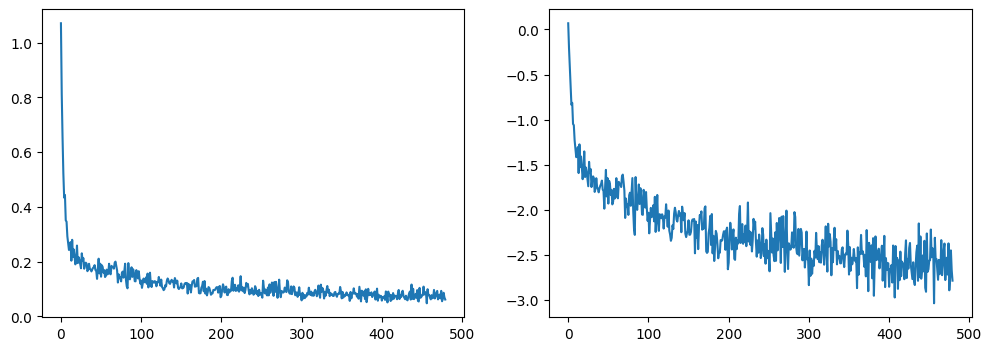

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

作为运行上述训练代码的替代方法，您可以像这样使用来自 pipeline 的模型：

In [ ]:
# Uncomment to instead load the model I trained earlier:
# model = butterfly_pipeline.unet

## 第6步：生成图像

我们如何用这个模型获得图像？

### 选项 1：创建一个 pipeline：

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

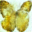

In [ ]:
pipeline_output = image_pipe()
pipeline_output.images[0]

我们可以将一个 pipeline 保存到本地文件夹，方法如下：

In [ ]:
image_pipe.save_pretrained("my_pipeline")

检查文件夹内容:

In [ ]:
!ls my_pipeline/

model_index.json  scheduler  unet


`scheduler` 和 `unet` 子文件夹包含重新创建这些组件所需的一切。例如，在 `unet` 文件夹中，你会发现模型权重（`diffusion_pytorch_model.bin`）以及一个指定 UNet 架构的配置文件。

In [ ]:
!ls my_pipeline/unet/

config.json  diffusion_pytorch_model.bin


Together, these files contain everything needed to recreate the pipeline. 您可以手动将它们上传到 hub，以与他人分享该 pipeline，或者查看下一节中的代码，通过 API 来实现此操作。

### 选项 2：编写采样循环

如果你检查管道的 forward 方法，你将能够看到当我们运行 `image_pipe()` 时发生了什么：

In [ ]:
# ??image_pipe.forward

我们从随机噪声开始，通过调度器的时间步长从最噪到最少噪运行，每一步根据模型预测去除少量的噪声：

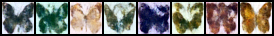

In [ ]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

`noise_scheduler.step()` 函数完成了更新 `sample` 所需的数学计算。有多种采样方法——在下一单元中，我们将看到如何更换不同的采样器以加速现有模型的图像生成，并进一步讨论从扩散模型中采样的理论基础。

## 第7步：将模型推送到Hub

在上面的例子中，我们将管道保存到了本地文件夹。为了将我们的模型推送到Hub，我们需要一个模型仓库来推送我们的文件。我们将根据要给模型的模型ID来确定仓库名称（可以随意替换 `model_name`，只需确保它包含您的用户名，这就是函数 `get_full_repo_name()` 所做的）。

In [ ]:
from huggingface_hub import get_full_repo_name

model_name = "sd-class-butterflies-32"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'lewtun/sd-class-butterflies-32'

接下来，在🤗 Hub 上创建一个模型仓库并推送我们的模型：

In [ ]:
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path="my_pipeline/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path="my_pipeline/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="my_pipeline/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

'https://huggingface.co/lewtun/sd-class-butterflies-32/blob/main/model_index.json'

最后要做的是创建一个漂亮的模型卡，以便我们的蝴蝶生成器可以在Hub上轻松被找到（随时可以扩展和编辑描述！）：

In [ ]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

现在模型已经在 Hub 上了，你可以通过使用 `DDPMPipeline` 的 `from_pretrained()` 方法从任何地方下载它，如下所示：

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

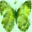

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline.from_pretrained(hub_model_id)
pipeline_output = image_pipe()
pipeline_output.images[0]

很好，它奏效了！

# 使用 🤗 Accelerate 进行扩展

本笔记本是为了学习目的而制作的，因此我尽量保持代码尽可能简洁和清晰。正因为如此，我们省略了一些你在尝试在更多数据上训练更大模型时可能需要的内容，例如多GPU支持、进度和示例图像的日志记录、用于支持更大批量的梯度检查点、模型的自动上传等。幸运的是，这些功能中的大多数都可以在示例训练脚本中找到，[点击这里查看](https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py)。

你可以像这样下载该文件:

In [ ]:
!wget https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py

打开文件，你会看到模型的定义位置以及可用的设置有哪些。我使用以下命令运行了脚本：

In [ ]:
# Let's give our new model a name for the Hub
model_name = "sd-class-butterflies-64"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'lewtun/sd-class-butterflies-64'

In [ ]:
!accelerate launch train_unconditional.py \
  --dataset_name="huggan/smithsonian_butterflies_subset" \
  --resolution=64 \
  --output_dir={model_name} \
  --train_batch_size=32 \
  --num_epochs=50 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_warmup_steps=500 \
  --mixed_precision="no"

和之前一样，让我们将模型推送到Hub，并创建一个漂亮的模型卡（并且随意根据你的意愿编辑它！）：

In [ ]:
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{model_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{model_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{model_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

'https://huggingface.co/lewtun/sd-class-butterflies-64/blob/main/README.md'

大约45分钟之后，这是结果：

  0%|          | 0/1000 [00:00<?, ?it/s]

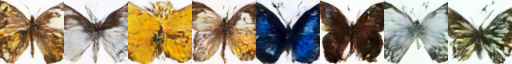

In [ ]:
pipeline = DDPMPipeline.from_pretrained(hub_model_id).to(device)
images = pipeline(batch_size=8).images
make_grid(images)

**练习：** 尝试找到能在尽可能短的时间内给出良好结果的训练/模型设置，并与社区分享你的发现。在脚本中深入探究，看看你是否能理解代码，并对任何看起来 confusing 的部分寻求澄清。

# 进一步探索的方向

希望这能让你了解使用🤗 Diffusers库可以做什么！以下是一些可能的下一步：

- 尝试在一个新数据集上训练一个无条件扩散模型 - 如果你[自己创建一个](https://huggingface.co/docs/datasets/image_dataset)，可以获得额外加分。你可以在Hub上的[HugGan组织](https://huggingface.co/huggan)中找到一些很棒的图像数据集来完成这个任务。只需确保在不想让模型训练太久的情况下对它们进行降采样！
- 尝试使用DreamBooth通过[这个Space](https://huggingface.co/spaces/multimodalart/dreambooth-training)或[这个notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_dreambooth_training.ipynb)创建自己的定制Stable Diffusion管道。
- 修改训练脚本来探索不同的UNet超参数（层数、通道数等），不同的噪声安排等。
- 查看[从零开始构建扩散模型](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/02_diffusion_models_from_scratch.ipynb)笔记本，以获取我们在此单元中涵盖的核心思想的不同视角。

祝你好运，并期待第二单元的内容！